# Learning the electron density of water

## Pre-requisites

### Install the relevant packages

1. `pip install metatensor`
1. `pip install chemiscope`
1. `pip install git+https://github.com/luthaf/rascaline.git@b2cedfe870541e6d037357db58de1901eb116c41`


**NOTE**: this notebook has only been tested on the HPC system "jed". Due to
specific compilation of the quantum chemistry package `FHI-aims`, the Python
interface to running QC calculations may not be generalized to other operating
systems or hardware.

In [1]:
%load_ext autoreload
%autoreload 2

# Useful standard and scientific ML libraries
import os
import ase.io
import matplotlib.pyplot as plt
import numpy as np
import py3Dmol
import torch

# M-Stack packages
import metatensor   # storage format for atomistic ML
import chemiscope  # interactive molecular visualization
import rascaline   # generating structural representations
from metatensor import Labels, TensorBlock, TensorMap
from rascaline.utils import clebsch_gordan

# Interfacing with FHI-aims
from rhocalc.aims import aims_calc, aims_parser

# Torch-based density leaning
from rholearn import io, data, loss, models, predictor
import settings

In [2]:
from settings import data_dir

# Define a function that returns the data directory for a given structure based
# on its structure index
def struct_dir(A):
    return os.path.join(data_dir, f"{A}/")

## Visualize structures in dataset

* Use `chemiscope`

In [3]:
from settings import all_idxs, frames

chemiscope.show(
    frames,
    properties={
        "Mean O-H bond length, Angstrom": [np.mean([f.get_distance(0, 1), f.get_distance(0, 2)]) for f in frames],
        "H-O-H angle, degrees": [f.get_angle(1, 0, 2) for f in frames],
    },
)

ChemiscopeWidget(value='{"meta": {"name": " "}, "structures": [{"size": 3, "names": ["O", "H", "H"], "x": [0.0…

## Generate learning targets

* These are the RI coefficients of the HOMO eigenstate
* We generate these in 2 steps: 1) SCF and 2) RI fitting

#### 1. Converge SCF for each structure

In [4]:
# Import the settings needed to run FHI-aims
from settings import aims_path, base_aims_kwargs, scf_kwargs, ri_kwargs, sbatch_kwargs

# Build a dict of settings for each calculation (i.e. structure)
# IMPORTANT: zip() is used to pair up the structure index and the structure
calcs = {
    A: {"atoms": frame, "run_dir": struct_dir(A)} for A, frame in zip(all_idxs, frames)
}

# And the general settings for all calcs
aims_kwargs = base_aims_kwargs.copy()
aims_kwargs.update(scf_kwargs)

# Run the SCF in AIMS
aims_calc.run_aims_array(
    calcs=calcs,
    aims_path=aims_path,
    aims_kwargs=aims_kwargs,
    sbatch_kwargs=sbatch_kwargs,
    run_dir=struct_dir,
)

Submitted batch job 11298209


sbatch: [ESTIMATION] The estimated cost of this job is CHF 5.60
sbatch: [CAPPING]    All users of the account cosmo-erc have consumed 102.81 CHF
sbatch: [CAPPING]    In addition, based on queued and running jobs all users of the account cosmo-erc will consume up to 0.00 CHF
sbatch: [CAPPING]    Your username abbott has consumed 0.78 CHF
sbatch: [CAPPING]    In addition, based on queued and running jobs your username abbott will consume up to 0.00 CHF
sbatch: ╭──────────────────────────────┬─────────────┬─────────────┬─────────────╮
sbatch: │ [in CHF]                     │ Capping     │ Consumed    │ Queued      │
sbatch: ├──────────────────────────────┼─────────────┼─────────────┼─────────────┤
sbatch: │ account : cosmo-erc          │ 1,610.653   │ 102.85      │ 0.0         │
sbatch: ├──────────────────────────────┼─────────────┼─────────────┼─────────────┤
sbatch: │ username : abbott            │ 0           │ 0.8         │ 0.0         │
sbatch: ╰──────────────────────────────┴───────

In [5]:
# Running this code will ensure that all calculations have finished.
# Should take < 10 seconds (1 node, 10 cores on 'jed' HPC)
all_finished = False
while not all_finished:
    calcs_finished = []
    for A in all_idxs:
        aims_out_path = os.path.join(struct_dir(A), "aims.out")
        if os.path.exists(aims_out_path):
            with open(aims_out_path, "r") as f:
                calcs_finished.append("Leaving FHI-aims." in f.read())  # AIMS finished
        else:
            calcs_finished.append(False)
    all_finished = np.all(calcs_finished)

# Check SCF converged
converged = []
for A in all_idxs:
    aims_out_path = os.path.join(struct_dir(A), "aims.out")
    if os.path.exists(aims_out_path):
        with open(aims_out_path, "r") as f:
            converged.append(
                "Self-consistency cycle converged." in f.read()
            )  # calculation converged
    else:
        converged.append(False)
if np.all(converged):
    print("All SCF calculations converged!")
else:
    print(
        "Some SCF calculations did not converge. structure idxs: ",
        [A for i, A in enumerate(all_idxs) if not converged[i]],
    )

All SCF calculations converged!


#### 2. Perform RI fitting on the scalar field of interest (HOMO)

* First we need to identify the HOMO
* This can be done by parsing the Kohn Sham orbital information from the
  converged SCF calculation. 
* This info got written to file "ks_orbital_info.out" above by using the
  `ri_fit_write_ks_orb_info: True` keyword set in `scf_kwargs`.

In [6]:
# Write KSO weights for just the HOMO to file
for A in all_idxs:
    # Parse the Kohn-Sham
    ks_info = aims_parser.get_ks_orbital_info(
        os.path.join(struct_dir(A), "ks_orbital_info.out")
    )
    kso_idxs = aims_parser.find_homo_kso_idxs(ks_info)
    weights = np.zeros(ks_info.shape[0])

    # For the HOMO states, add a weighting of 1.0
    for kso_idx in kso_idxs:  # these are 1-indexed in AIMS
        weights[kso_idx - 1] = 1.0

    # Save these to file so AIMS can read them in
    np.savetxt(os.path.join(struct_dir(A), "ks_orbital_weights.in"), weights)

In [7]:
# And the general settings for all calcs
aims_kwargs = base_aims_kwargs.copy()
aims_kwargs.update(ri_kwargs)

# Run the RI fitting procedure in AIMS
restart_idx = 0
aims_calc.run_aims_array(
    calcs=calcs,
    aims_path=aims_path,
    aims_kwargs=aims_kwargs,
    sbatch_kwargs=sbatch_kwargs,
    run_dir=struct_dir,
    restart_idx=0,   # Restart from a converged SCF
    copy_files=["ks_orbital_weights.in"],  # Copy the KS weights into the restart dir
)

Submitted batch job 11298309


sbatch: [ESTIMATION] The estimated cost of this job is CHF 5.60
sbatch: [CAPPING]    All users of the account cosmo-erc have consumed 102.81 CHF
sbatch: [CAPPING]    In addition, based on queued and running jobs all users of the account cosmo-erc will consume up to 0.00 CHF


In [8]:
# Running this code will ensure that all calculations have finished
# Should take < 30 seconds (1 node, 10 cores, on 'jed' HPC)
all_finished = False
while not all_finished:
    calcs_finished = []
    for A in all_idxs:
        aims_out_path = os.path.join(struct_dir(A), f"{restart_idx}/aims.out")
        if os.path.exists(aims_out_path):
            with open(aims_out_path, "r") as f:
                calcs_finished.append("Leaving FHI-aims." in f.read())  # AIMS finished
        else:
            calcs_finished.append(False)
    all_finished = np.all(calcs_finished)

In [9]:
processed_dir = lambda A: os.path.join(struct_dir(A), "0/processed/")  # includes restart index

In [11]:
# Process AIMS results and print density fitting error
# Run in serial: takes approx 30 seconds per structure
df_errors = []
for A, frame in zip(all_idxs, frames):
    aims_parser.process_aims_ri_results(
        frame=frame,
        aims_output_dir=os.path.join(struct_dir(A), "0"),  # includes the restart idx
        process_what=["coeffs", "ovlp"],
        structure_idx=A,
    )
    calc_info = io.unpickle_dict(os.path.join(processed_dir(A), "calc_info.pickle"))
    df_errors.append(calc_info["df_error_percent"]["total"])
print("Mean density fitting error across all structures (%):", np.mean(df_errors))

Mean density fitting error across all structures(%): 0.37925302580513093


## Build Structural Descriptors 

* Here we construct $\lambda$-SOAP equivariant descriptors for each structure
* First, find the angular orders present in the decomposition of the target
  scalar field onto the RI basis

In [13]:
# The basis set definition should is consistent for all atoms in the dataset,
# given consistent AIMS settings. Print this definiton from the parsed outputs
# from the first structure (A = 0)
basis_set = io.unpickle_dict(
    os.path.join(processed_dir(A=0), "calc_info.pickle")
)["basis_set"]

basis_set["def"]

{'lmax': {'O': 8, 'H': 4},
 'nmax': {('O', 0): 9,
  ('O', 1): 10,
  ('O', 2): 9,
  ('O', 3): 8,
  ('O', 4): 6,
  ('O', 5): 4,
  ('O', 6): 4,
  ('O', 7): 2,
  ('O', 8): 1,
  ('H', 0): 9,
  ('H', 1): 7,
  ('H', 2): 6,
  ('H', 3): 3,
  ('H', 4): 1}}

The maximum angular order here is $l = 8$. This should be reflected in the
settings used to generate the equivariant descriptor - specifically in
`cg_settings` in "settings.py".

In [14]:
from settings import rascal_settings, cg_settings

# Generate a rascaline SphericalExpansion (2 body) representation
calculator = rascaline.SphericalExpansion(**rascal_settings["hypers"])
nu_1_tensor = calculator.compute(frames, **rascal_settings["compute"])
nu_1_tensor = nu_1_tensor.keys_to_properties("species_neighbor")

# Build a lambda-SOAP descriptor by a CLebsch-Gordan combination
lsoap = clebsch_gordan.lambda_soap_vector(nu_1_tensor, **cg_settings)

# Split into per-structure TensorMaps and save into separate directories.
# This is useful for batched training.
for A in all_idxs:
    lsoap_A = metatensor.slice(
        lsoap,
        "samples",
        labels=Labels(names="structure", values=np.array([A]).reshape(-1, 1)),
    )
    metatensor.save(os.path.join(processed_dir(A), "lsoap.npz"), lsoap_A)

The settings used to build the descriptor from an `.xyz` file, as well as build
the desired target property (the real-space scalar field) from the model
prediction need to be stored so that the perform can make a true end-to-end
prediction.

In the `rholearn` module "predictor.py", the functions `descriptor_builder` and
`target_builder` are implemented to perform these transformations on the input
and output side of the model, respectively. Both take a
variable input that depends on the structure being predicted on, and some
settings for performing the relevant transformations of the data. The key
physics-related settings used in predicting on an unseen structure shouldbe the
same as were used for generating the data the model was trained on.

Here we store the relevant settings in dictionaries, which will be used to
initialize the ML model later.

In [15]:
# For descriptor building, we need to store the rascaline settings for
# generating a SphericalExpansion and performing Clebsch-Gordan combinations.
# The `descriptor_builder` function in "predictor.py" contains the 'recipe' for
# using these settings to transform an ASE Atoms object.
descriptor_kwargs = {
    "rascal_settings": rascal_settings,
    "cg_settings": cg_settings,
}

In [16]:
# For target building, the base AIMS settings need to be stored, along with the
# basis set definition.
target_kwargs = {
    "aims_kwargs": {**base_aims_kwargs},
    "basis_set": {**basis_set},
}

## Create `dataset` and `dataloader`

* For cross-validation we create a train-test-val split of the data.
* Then we initialize `metatensor`/`torch` DataSet and DataLoader objects to
  allow for easy with mini-batching

In [17]:
from settings import crossval_settings

train_idxs, test_idxs, val_idxs = data.group_idxs(
    all_idxs=all_idxs,
    n_groups=crossval_settings["n_groups"],
    group_sizes=crossval_settings["group_sizes"],
    shuffle=crossval_settings["shuffle"],
    seed=crossval_settings["seed"],
)
print("num train_idxs:", len(train_idxs), "   num test_idxs: ", len(test_idxs), "   num val_idxs:", len(val_idxs))

num train_idxs: 50    num test_idxs:  30    num val_idxs: 20


In [22]:
from settings import torch_settings, ml_settings

In [ ]:
# Build the torch dataset
rho_data = data.RhoData(
    all_idxs=np.concatenate([train_idxs, test_idxs, val_idxs]),
    train_idxs=train_idxs,
    in_path=lambda A: os.path.join(processed_dir(A), "lsoap.npz"),
    out_path=lambda A: os.path.join(processed_dir(A), "ri_coeffs.npz"),
    aux_path=lambda A: os.path.join(processed_dir(A), "ri_ovlp.npz"),
    keep_in_mem=ml_settings["loading"]["train"]["keep_in_mem"],
    # calc_out_train_inv_means=True,
    # calc_out_train_std_dev=True,
    **torch_settings,
)

In [23]:
# Here we initialize the model with the model architecture options, as well as
# the descriptor/target builder settings needed for end-to-end predictions.
model = models.RhoModel(
    model_type=ml_settings["model"]["model_type"],
    input=rho_data[0][1],   # for initializing ... 
    output=rho_data[0][2],  # ... the metadata of the model
    bias_invariants=ml_settings["model"]["bias_invariants"],
    # hidden_layer_widths=[8, 8],
    # activation_fn=torch.nn.Tanh(),
    descriptor_kwargs=descriptor_kwargs,
    target_kwargs=target_kwargs,
    **torch_settings
)

## Model training

* Now we are ready to train a model

In [24]:
# Construct dataloaders for training and testing
batch_size = 5
train_loader = data.RhoLoader(
    rho_data,
    idxs=train_idxs,
    get_aux_data=True,
    batch_size=batch_size,
)
test_loader = data.RhoLoader(
    rho_data,
    idxs=test_idxs,
    get_aux_data=True,
    batch_size=batch_size,
)

In [25]:
# Initialize optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = loss.L2Loss()

In [27]:
n_epochs = 1

# Start training loop
losses = {"train": [], "test": []}
for epoch in range(1, n_epochs + 1):
    # Switch off metadata checking after the first epoch
    check_args = True if epoch == 0 else False

    # Iterate over train batches
    train_loss_epoch = 0
    for train_batch in train_loader:
        # Reset gradients
        optimizer.zero_grad()

        # Unpack train batch, respectively: structure idxs, lsoap, RI coeffs, RI
        # overlap matrices
        idxs_train, in_train, out_train, aux_train = train_batch

        # Make a prediction
        out_train_pred = model(in_train, check_args=check_args)

        # Evaluate training loss
        train_loss_batch = loss_fn(
            input=out_train_pred,
            target=out_train,
            overlap=aux_train,
            check_args=check_args,
        )

        # Calculate gradient and update parameters
        train_loss_batch.backward()
        optimizer.step()

        train_loss_epoch += train_loss_batch

    train_loss_epoch /= len(idxs_train)
    losses["train"].append(train_loss_epoch.detach().numpy())

    # Iterate over test batches: calculate the test loss
    with torch.no_grad():  # don't track gradients for test loss
        test_loss_epoch = 0
        for test_batch in test_loader:
            # Unpack test batch
            idxs_test, in_test, out_test, aux_test = test_batch

            # Make a prediction
            out_test_pred = model(in_test, check_args=check_args)

            # Evaluate test loss
            test_loss_batch = loss_fn(
                input=out_test_pred,
                target=out_test,
                overlap=aux_test,
                check_args=check_args,
            )
            test_loss_epoch += test_loss_batch

        test_loss_epoch /= len(idxs_test)
        losses["test"].append(test_loss_epoch.detach().numpy())

    print(
        f"Epoch {epoch} | Train loss: {train_loss_epoch} | Test loss: {test_loss_epoch}"
    )

Epoch 0 | Train loss: 4.981271746697425 | Test loss: 0.4470236234203514


Text(0, 0.5, 'Density loss per structure')

/home/abbott/miniforge3/envs/rho/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  func(*args, **kwargs)


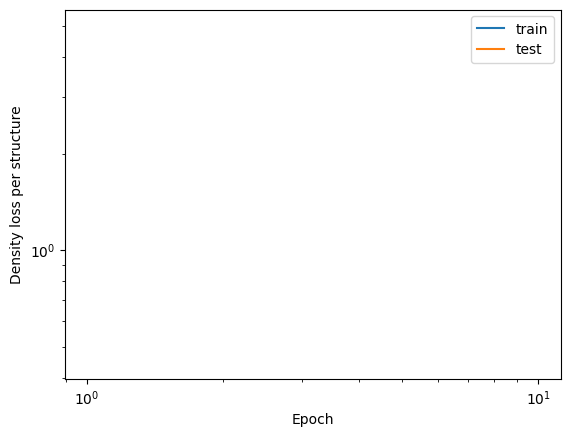

In [28]:
# Plot losses
fig, ax = plt.subplots()
for trace in ["train", "test"]:
    ax.loglog(np.arange(n_epochs), losses[trace], label=trace)

ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Density loss per structure")

## Evaluate model performance on validation set



In [34]:
# Create a callable for directories to save predictions by structure index
def save_dir(A):
    return os.path.join("/scratch/abbott/h2o_homo/ml/predictions", f"{A}")

# Settings specific to RI rebuild procedure
ri_kwargs = {
    # Force no SCF
    "sc_iter_limit": 0,
    "postprocess_anyway": True,
    "ri_fit_assume_converged": True,
    # What we want to do 
    "ri_fit_rebuild_from_coeffs": True,
    # What we want to output
    "ri_fit_write_rebuilt_field": True,
    "ri_fit_write_rebuilt_field_cube": True,
    "output": ["cube ri_fit"],  # needed for cube files
}

# Update the AIMS and SBATCH kwargs
tmp_aims_kwargs = {**model.target_kwargs["aims_kwargs"]}
tmp_aims_kwargs.update(ri_kwargs)

# Settings for slurm
sbatch_kwargs = {
    "job-name": "h2o-pred",
    "nodes": 1,
    "time": "01:00:00",
    "mem-per-cpu": 2000,
    "partition": "standard",
    "ntasks-per-node": 10,
}

model.update_target_kwargs(
    {
        "aims_path": aims_path,
        "aims_kwargs": tmp_aims_kwargs,
        "sbatch_kwargs": sbatch_kwargs,
        "save_dir": save_dir,
    }
)

In [40]:
# For the validation set, we already have generated the descriptors so we just
# need to load them. First, build the validation dataloader
val_loader = data.RhoLoader(
    rho_data,
    idxs=val_idxs,
    get_aux_data=False,
    batch_size=None,
)
idxs_val, in_val, out_val = next(iter(val_loader))

# Load the validation frames as ASE Atoms objects
val_frames = [frames[A] for A in idxs_val]

In [46]:
# Make predictions for the validation set
predictions, targets = model.predict(structure_idxs=idxs_val, frames=val_frames, descriptor=in_val)

/home/abbott/miniforge3/envs/rho/lib/python3.10/site-packages/rholearn/models.py:345: UserWarning: one or more of input blocks at keys [LabelsEntry(spherical_harmonics_l=5, species_center=1), LabelsEntry(spherical_harmonics_l=6, species_center=1), LabelsEntry(spherical_harmonics_l=7, species_center=1), LabelsEntry(spherical_harmonics_l=8, species_center=1)] is not  part of the keys of the model. The returned prediction will not contain this block.
  warnings.warn(


Submitted batch job 11298495


In [55]:
# Calculate density fitting error of predictions relative to SCF-converged
# quantities
for A, target in zip(idxs_val, targets):
    # Get grids and check they're the same in the SCF and ML directories
    grid = np.loadtxt(os.path.join(struct_dir(A), "0/partition_tab.out"))
    assert np.allclose(grid, np.loadtxt(os.path.join(model.target_kwargs["save_dir"](A), "partition_tab.out")))

    # Get DF error
    df_error = aims_parser.get_percent_mae_between_fields(
        input=target,
        target=np.loadtxt(os.path.join(struct_dir(A), "0/rho_ref.out")), 
        grid=grid,
    )
    print(f"Val structure {A}, DF error (%): {df_error}")

ValueError: grid points not equivalent between input scalar field and integration weights

In [56]:
target

array([[-2.012818e+00, -1.106351e+01, -1.903970e+00, -1.454905e-14],
       [-1.118286e+00, -1.071142e+01, -3.697846e+00, -2.577719e-14],
       [-3.806694e+00, -1.071142e+01, -1.009438e+00, -2.072097e-13],
       ...,
       [-8.835566e+00,  1.423274e+01,  6.524662e-01,  0.000000e+00],
       [-7.204094e-01,  1.071948e+01,  1.228088e+01,  0.000000e+00],
       [-7.204094e-01,  1.423274e+01,  8.767622e+00,  0.000000e+00]])

In [57]:
np.loadtxt(os.path.join(struct_dir(A), "0/rho_ri.out"))

array([[-3.254106e+00, -1.045188e+01, -3.394783e+00,  2.364527e-25],
       [-2.012355e+00, -1.106351e+01, -2.153032e+00,  2.315427e-25],
       [-8.488107e-01, -1.136375e+01, -9.894876e-01,  6.579252e-26],
       ...,
       [ 7.823999e+00,  1.246209e+01,  6.019372e+00, -1.034384e-38],
       [ 3.044258e-01,  1.293489e+01,  1.071833e+01, -2.147385e-42],
       [ 8.419582e+00,  1.293489e+01,  2.603176e+00,  1.365319e-38]])

## Make a prediction on unseen structures

In [ ]:
# Load some structures we don't have a DFT reference for
unseen_structures = ase.io.read(
    os.path.join(data_dir, "water_monomers_1k.xyz"), f"{n_frames}:{n_frames + 5}"
)

# Make an end-to-end prediction: XYZ coordinates ---> RI coefficients
model.predict(frames=unseen_structures)

In [ ]:
# Visualize the predicted density
A = idxs_val[0]
val_cube = os.path.join(model.target_kwargs["save_dir"](A), "rho_rebuilt.cube")
v = py3Dmol.view()
v.addModelsAsFrames(open(val_cube, "r").read(), "cube")
v.setStyle({"stick": {}})
v.addVolumetricData(
    open(val_cube, "r").read(),
    "cube",
    {"isoval": 0.005, "color": "blue", "opacity": 0.8},
)
v.show()

# Visualize the delta density

In [ ]:
# Visualize the predicted density
A = idxs_val[0]
val_cube = os.path.join(struct_dir(A), "0/rho_ref.cube")
v = py3Dmol.view()
v.addModelsAsFrames(open(val_cube, "r").read(), "cube")
v.setStyle({"stick": {}})
v.addVolumetricData(
    open(val_cube, "r").read(),
    "cube",
    {"isoval": 0.005, "color": "blue", "opacity": 0.8},
)
v.show()

# Visualize the delta density